In [1]:
import sys 
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
import warnings
import seaborn as sns
# To suppress all warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import  r2_score as r2
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
from database import Magneticum
from relation import Scaling
from relation import Distribution
from relation import Analysis
from relation import RandomForest

In [3]:
def data_manupulation(df):
    dff = df.copy()
    dff = dff[['Yksz','Vz','Mstar', 'M','Vlos']]
    dff.Vz = dff.Vz.apply(lambda x: x/1e5)
    dff.Mstar = dff.Mstar.apply(lambda x: np.log(x))
    q_list = [0,0.25,0.5,0.75,1]
    labels = [1,2,3,4]
    dff['M_q'] = pd.qcut(dff['M'],q=q_list,labels=labels)
    return dff

In [4]:
snaps = ['140','132','096']

In [5]:
boxno = 50

In [6]:
df_140 = Analysis(boxno,'140','').get_dataframe()
df_132 = Analysis(boxno,'132','').get_dataframe()
df_096 = Analysis(boxno,'096','').get_dataframe()

In [7]:
df_140_m = data_manupulation(df_140)
df_132_m = data_manupulation(df_132)
df_096_m = data_manupulation(df_096)

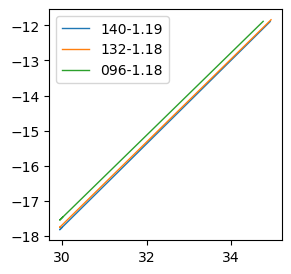

In [8]:
plt.figure(figsize=(3,3))
i = 0
rmse = []
r2 = []
for df in [df_140_m,df_132_m,df_096_m]:
    slope, intercept = np.polyfit(df.M, df.Yksz, 1)
    best_fit_line = slope*df.M+intercept
    rmse.append(mean_squared_error(df.Yksz, best_fit_line,squared=False))
    r2.append(r2_score(df.Yksz, best_fit_line))
    plt.plot(df.M, best_fit_line,linewidth=1,label=f'{snaps[i]}-{slope:.2f}')
    i+=1
plt.legend()

In [9]:
rmse

[1.144756036078561, 1.1447587085569164, 1.1244581168776409]

In [10]:
r2

[0.34849521792878235, 0.3381751247675967, 0.3025901128859617]

In [11]:
def fit_regression_models(df, features, target):
    print(f'Features: {features}')
    X = df[features].values.reshape(-1, len(features))
    y = df[target].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=df.M_q, random_state=42)

    # Initialize regression models
    models = {
        "Random Forest Regression": RandomForestRegressor(max_depth=10,min_samples_leaf=4,min_samples_split=10,n_estimators=200, random_state=42),
        "XGB": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        "GradientBoost": GradientBoostingRegressor(random_state=42),
        }

    results = {}

    for model_name, model in models.items():
        # Fit the model
        # if model_name == "Perceptron":
        #     model.fit(X_train, y_train,)
        # else:
        model.fit(X_train, y_train,sample_weight=np.sqrt(X_train[:,0]))

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        results[model_name] = {"RMSE": rmse, "R-squared": r2}

        # Plot the results
        # plt.clf()
        # plt.figure(figsize=(6, 4))
        # plt.scatter(X_test[:, 0], y_test, color='blue', label='True')
        # plt.scatter(X_test[:, 0], y_pred, color='red', label='Predicted')
        # plt.xlabel(features[0])
        # plt.ylabel(target)
        # plt.legend()
        # plt.title(f'{model_name} - RMSE: {rmse:.2f}, R-squared: {r2:.2f}')
        # plt.show()

    return results

In [20]:
def get_results(df):
    results_M = fit_regression_models(df, ['M'], 'Yksz')
    results_MM = fit_regression_models(df, ['M','Mstar'], 'Yksz')
    # Fit models using '[M, Vz]'
    results_MVz = fit_regression_models(df, ['M', 'Vz'], 'Yksz')

    # Fit models using '[M, Mstar, Vz]'
    results_MMVz = fit_regression_models(df, ['M', 'Mstar', 'Vz'], 'Yksz')
    return results_M,results_MM,results_MVz,results_MMVz


In [21]:
results_M,results_MM,results_MVz,results_MMVz = get_results(df_140_m)
# Print and compare the results
for feature_set, result in zip(['M','[M,Mstar]','[M, Vz]', '[M, Mstar, Vz]'],
                               [results_M, results_MM, results_MVz, results_MMVz]):
    print(f"Results for {feature_set}:")
    for model_name, metrics in result.items():
        print(f"{model_name} - RMSE: {metrics['RMSE']:.2f}, R-squared: {metrics['R-squared']:.2f}")
    print()

Features: ['M']


Features: ['M', 'Mstar']
Features: ['M', 'Vz']
Features: ['M', 'Mstar', 'Vz']
Results for M:
Random Forest Regression - RMSE: 1.20, R-squared: 0.30
XGB - RMSE: 1.20, R-squared: 0.31
GradientBoost - RMSE: 1.20, R-squared: 0.31

Results for [M,Mstar]:
Random Forest Regression - RMSE: 1.20, R-squared: 0.31
XGB - RMSE: 1.21, R-squared: 0.29
GradientBoost - RMSE: 1.19, R-squared: 0.32

Results for [M, Vz]:
Random Forest Regression - RMSE: 0.93, R-squared: 0.58
XGB - RMSE: 0.94, R-squared: 0.58
GradientBoost - RMSE: 0.92, R-squared: 0.59

Results for [M, Mstar, Vz]:
Random Forest Regression - RMSE: 0.93, R-squared: 0.59
XGB - RMSE: 0.93, R-squared: 0.59
GradientBoost - RMSE: 0.92, R-squared: 0.59



In [22]:
results_M,results_MM,results_MVz,results_MMVz = get_results(df_132_m)
# Print and compare the results
for feature_set, result in zip(['M','[M,Mstar]', '[M, Vz]', '[M, Mstar, Vz]'],
                               [results_M, results_MM, results_MVz, results_MMVz]):
    print(f"Results for {feature_set}:")
    for model_name, metrics in result.items():
        print(f"{model_name} - RMSE: {metrics['RMSE']:.2f}, R-squared: {metrics['R-squared']:.2f}")
    print()

Features: ['M']


Features: ['M', 'Mstar']
Features: ['M', 'Vz']
Features: ['M', 'Mstar', 'Vz']
Results for M:
Random Forest Regression - RMSE: 1.16, R-squared: 0.32
XGB - RMSE: 1.16, R-squared: 0.33
GradientBoost - RMSE: 1.15, R-squared: 0.33

Results for [M,Mstar]:
Random Forest Regression - RMSE: 1.16, R-squared: 0.32
XGB - RMSE: 1.17, R-squared: 0.32
GradientBoost - RMSE: 1.15, R-squared: 0.33

Results for [M, Vz]:
Random Forest Regression - RMSE: 0.87, R-squared: 0.62
XGB - RMSE: 0.88, R-squared: 0.61
GradientBoost - RMSE: 0.87, R-squared: 0.62

Results for [M, Mstar, Vz]:
Random Forest Regression - RMSE: 0.87, R-squared: 0.62
XGB - RMSE: 0.88, R-squared: 0.61
GradientBoost - RMSE: 0.87, R-squared: 0.62



In [25]:
results_M,results_MM,results_MVz,results_MMVz = get_results(df_096_m)
# Print and compare the results
for feature_set, result in zip(['M', '[M,Mstar]','[M, Vz]', '[M, Mstar, Vz]'],
                               [results_M,results_MM, results_MVz, results_MMVz]):
    print(f"Results for {feature_set}:")
    for model_name, metrics in result.items():
        print(f"{model_name} - RMSE: {metrics['RMSE']:.2f}, R-squared: {metrics['R-squared']:.2f}")
    print()

Features: ['M']
Features: ['M', 'Mstar']
Features: ['M', 'Vz']
Features: ['M', 'Mstar', 'Vz']
Results for M:
Random Forest Regression - RMSE: 1.14, R-squared: 0.27
XGB - RMSE: 1.14, R-squared: 0.28
GradientBoost - RMSE: 1.13, R-squared: 0.29

Results for [M,Mstar]:
Random Forest Regression - RMSE: 1.13, R-squared: 0.28
XGB - RMSE: 1.15, R-squared: 0.26
GradientBoost - RMSE: 1.13, R-squared: 0.29

Results for [M, Vz]:
Random Forest Regression - RMSE: 0.86, R-squared: 0.58
XGB - RMSE: 0.88, R-squared: 0.57
GradientBoost - RMSE: 0.86, R-squared: 0.59

Results for [M, Mstar, Vz]:
Random Forest Regression - RMSE: 0.86, R-squared: 0.59
XGB - RMSE: 0.87, R-squared: 0.58
GradientBoost - RMSE: 0.85, R-squared: 0.59



In [28]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D


In [8]:
plt.rcParams['text.usetex']=True
plt.rcParams['ytick.minor.visible'] =True
plt.rcParams['xtick.minor.visible'] = True

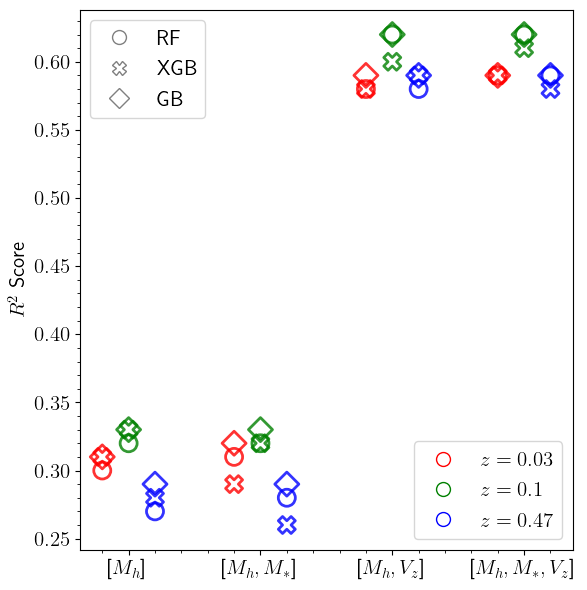

In [45]:

# Data for R2 scores
parameters = ['[M_h]', '[M_h,M_*]', '[M_h,V_z]', '[M_h,M_*,V_z]']
labels = ['[$M_h$]', '[$M_h,M_*$]', '[$M_h,V_z$]', '[$M_h,M_*,V_z$]']

# R2 scores for each model and redshift
scores = {
    'RF': {
        '0.03': [0.30, 0.31, 0.58, 0.59],
        '0.1': [0.32, 0.32, 0.62, 0.62],
        '0.47': [0.27, 0.28, 0.58, 0.59]
    },
    'XGB': {
        '0.03': [0.31, 0.29, 0.58, 0.59],
        '0.1': [0.33, 0.32, 0.60, 0.61],
        '0.47': [0.28, 0.26, 0.59, 0.58]
    },
    'GB': {
        '0.03': [0.31, 0.32, 0.59, 0.59],
        '0.1': [0.33, 0.33, 0.62, 0.62],
        '0.47': [0.29, 0.29, 0.59, 0.59]
    }
}

# Colors and markers for the plots
markers = {'RF': 'o', 'XGB': 'X', 'GB': 'D'}  # o: circle, X: x-mark, D: diamond
redshifts = ['0.03', '0.1', '0.47']
colors = ['red', 'green', 'blue']  # Colors for redshifts 0.03, 0.1, 0.47 respectively

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Set the positions of the x-ticks for each parameter set
x = np.arange(len(parameters))
width = 0.2  # the width of the bars

# Plot each model's performance with outlined markers
for i, (model, marker) in enumerate(markers.items()):
    for j, redshift in enumerate(redshifts):
        # Calculate bar positions
        positions = x - (1 - j) * width if j < 2 else x + (j - 1) * width
        # Plot each set of parameters
        ax.scatter(positions, scores[model][redshift], alpha=0.8, label=f'{model} (z={redshift})', 
                   edgecolor=colors[j], marker=marker, facecolors='none', s=150, linewidths=2)

# Customize the axes and labels
ax.set_xticks(x,)
ax.set_xticklabels(labels, fontsize=15)
#ax.set_xlabel('Parameters Used in Regression', fontsize=14)
ax.set_ylabel(r'$R^2$ Score', fontsize=15)

# Creating a custom legend for the regression methods
legend_elements_models = [Line2D([0], [0], marker='o', color='w', label='RF', markerfacecolor='none', markeredgecolor='grey', markersize=10),
                          Line2D([0], [0], marker='X', color='w', label='XGB', markerfacecolor='none', markeredgecolor='grey', markersize=10),
                          Line2D([0], [0], marker='D', color='w', label='GB', markerfacecolor='none', markeredgecolor='grey', markersize=10)]

# Creating a custom legend for the redshifts
legend_elements_redshifts = [Line2D([0], [0], marker='o', color='w', label='$z = 0.03$', markerfacecolor='none', markeredgecolor='red', markersize=10),
                             Line2D([0], [0], marker='o', color='w', label='$z = 0.1$', markerfacecolor='none', markeredgecolor='green', markersize=10),
                             Line2D([0], [0], marker='o', color='w', label='$z = 0.47$', markerfacecolor='none', markeredgecolor='blue', markersize=10)]

# Add legends to the plot
legend1 = ax.legend(handles=legend_elements_models,  loc='upper left',fontsize=15) #title="Regression Methods"
legend2 = ax.legend(handles=legend_elements_redshifts, loc='lower right',fontsize=15)#, title="Redshifts"
plt.gca().add_artist(legend1)
plt.yticks(fontsize=15)
# Show plot with a tight layout
plt.tight_layout()
plt.savefig('r2.pdf',dpi=300)


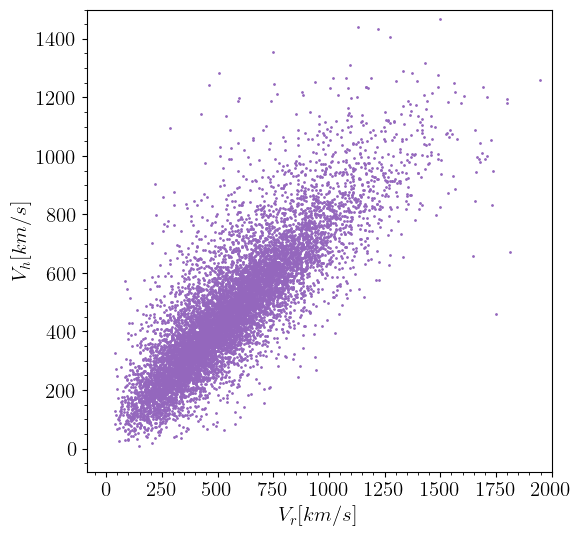

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(df_140.Vnet/1e5,df_140.vnet,s=1,c='C4',label='$z=0.03$')
plt.xlabel('$V_{r}[km/s]$',fontsize=15)
plt.ylabel('$V_{h}[km/s]$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(None,2000)
plt.ylim(None,1500)
#plt.legend(fontsize=20)
plt.savefig('vr_vh.pdf',dpi=300)


In [73]:
np.corrcoef(df_140.Vnet/1e5,df_140.vnet)

array([[1.        , 0.84388103],
       [0.84388103, 1.        ]])